In [1]:
import sys
sys.path.append('/home/monte.flora/python_packages/scikit-explain/')
sys.path.append('/home/monte.flora/python_packages/master/ml_workflow')
sys.path.append('/work/mflora/ROAD_SURFACE')
import skexplain
from os.path import join
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
from glob import glob
import joblib
import matplotlib.pyplot as plt
from display_names import to_readable_names, get_units, to_color, WOFS_FEATURE_NAMES

from probsr_config import PREDICTOR_COLUMNS, FIGURE_MAPPINGS, COLOR_DICT
from skexplain.common.importance_utils import to_skexplain_importance
from load_rankings import load_imp

In [2]:
import xarray as xr
def to_xarray(shap_data, estimator_name, feature_names=None):
    dataset={}
    
    shap_values = shap_data['shap_values']
    bias = shap_data['bias']
    
    dataset[f'shap_values__{estimator_name}'] = (['n_examples', 'n_features'], shap_values)
    dataset[f'bias__{estimator_name}'] = (['n_examples'], bias.astype(np.float64))
    dataset['X'] = (['n_examples', 'n_features'], shap_data['X'])
    dataset['y'] = (['n_examples'], shap_data['targets'])
    
    ds = xr.Dataset(dataset)
    #ds.attrs['features'] = feature_names
    
    return ds 

In [3]:
hazard = 'tornado'

In [4]:
display_feature_names = {f : to_readable_names(f) for f in WOFS_FEATURE_NAMES}
feature_colors = {f : to_color(f) for f in WOFS_FEATURE_NAMES}

feature_colors = {**feature_colors, **COLOR_DICT}
display_feature_names = {**display_feature_names, **FIGURE_MAPPINGS}

In [5]:
explainer = skexplain.ExplainToolkit(seaborn_kws={'style' : 'dark'})

In [7]:
results, methods, name, features = load_imp(hazard, 'original')
names = [name]*len(methods)
data = results

In [8]:
names = [name]*len(methods)
data=[]
for ds,m, name in zip(results, methods, names):
    imp = ds[f'{m}_scores__{name}'].values
    imp[imp==0] = 0.000001

    imp_norm = imp / (np.percentile(imp, 99) - np.percentile(imp, 1))
            
    ds[f'{m}_scores__{name}'] = ([f'n_vars_{m}', 'n_permute'], imp_norm)
    data.append(ds)

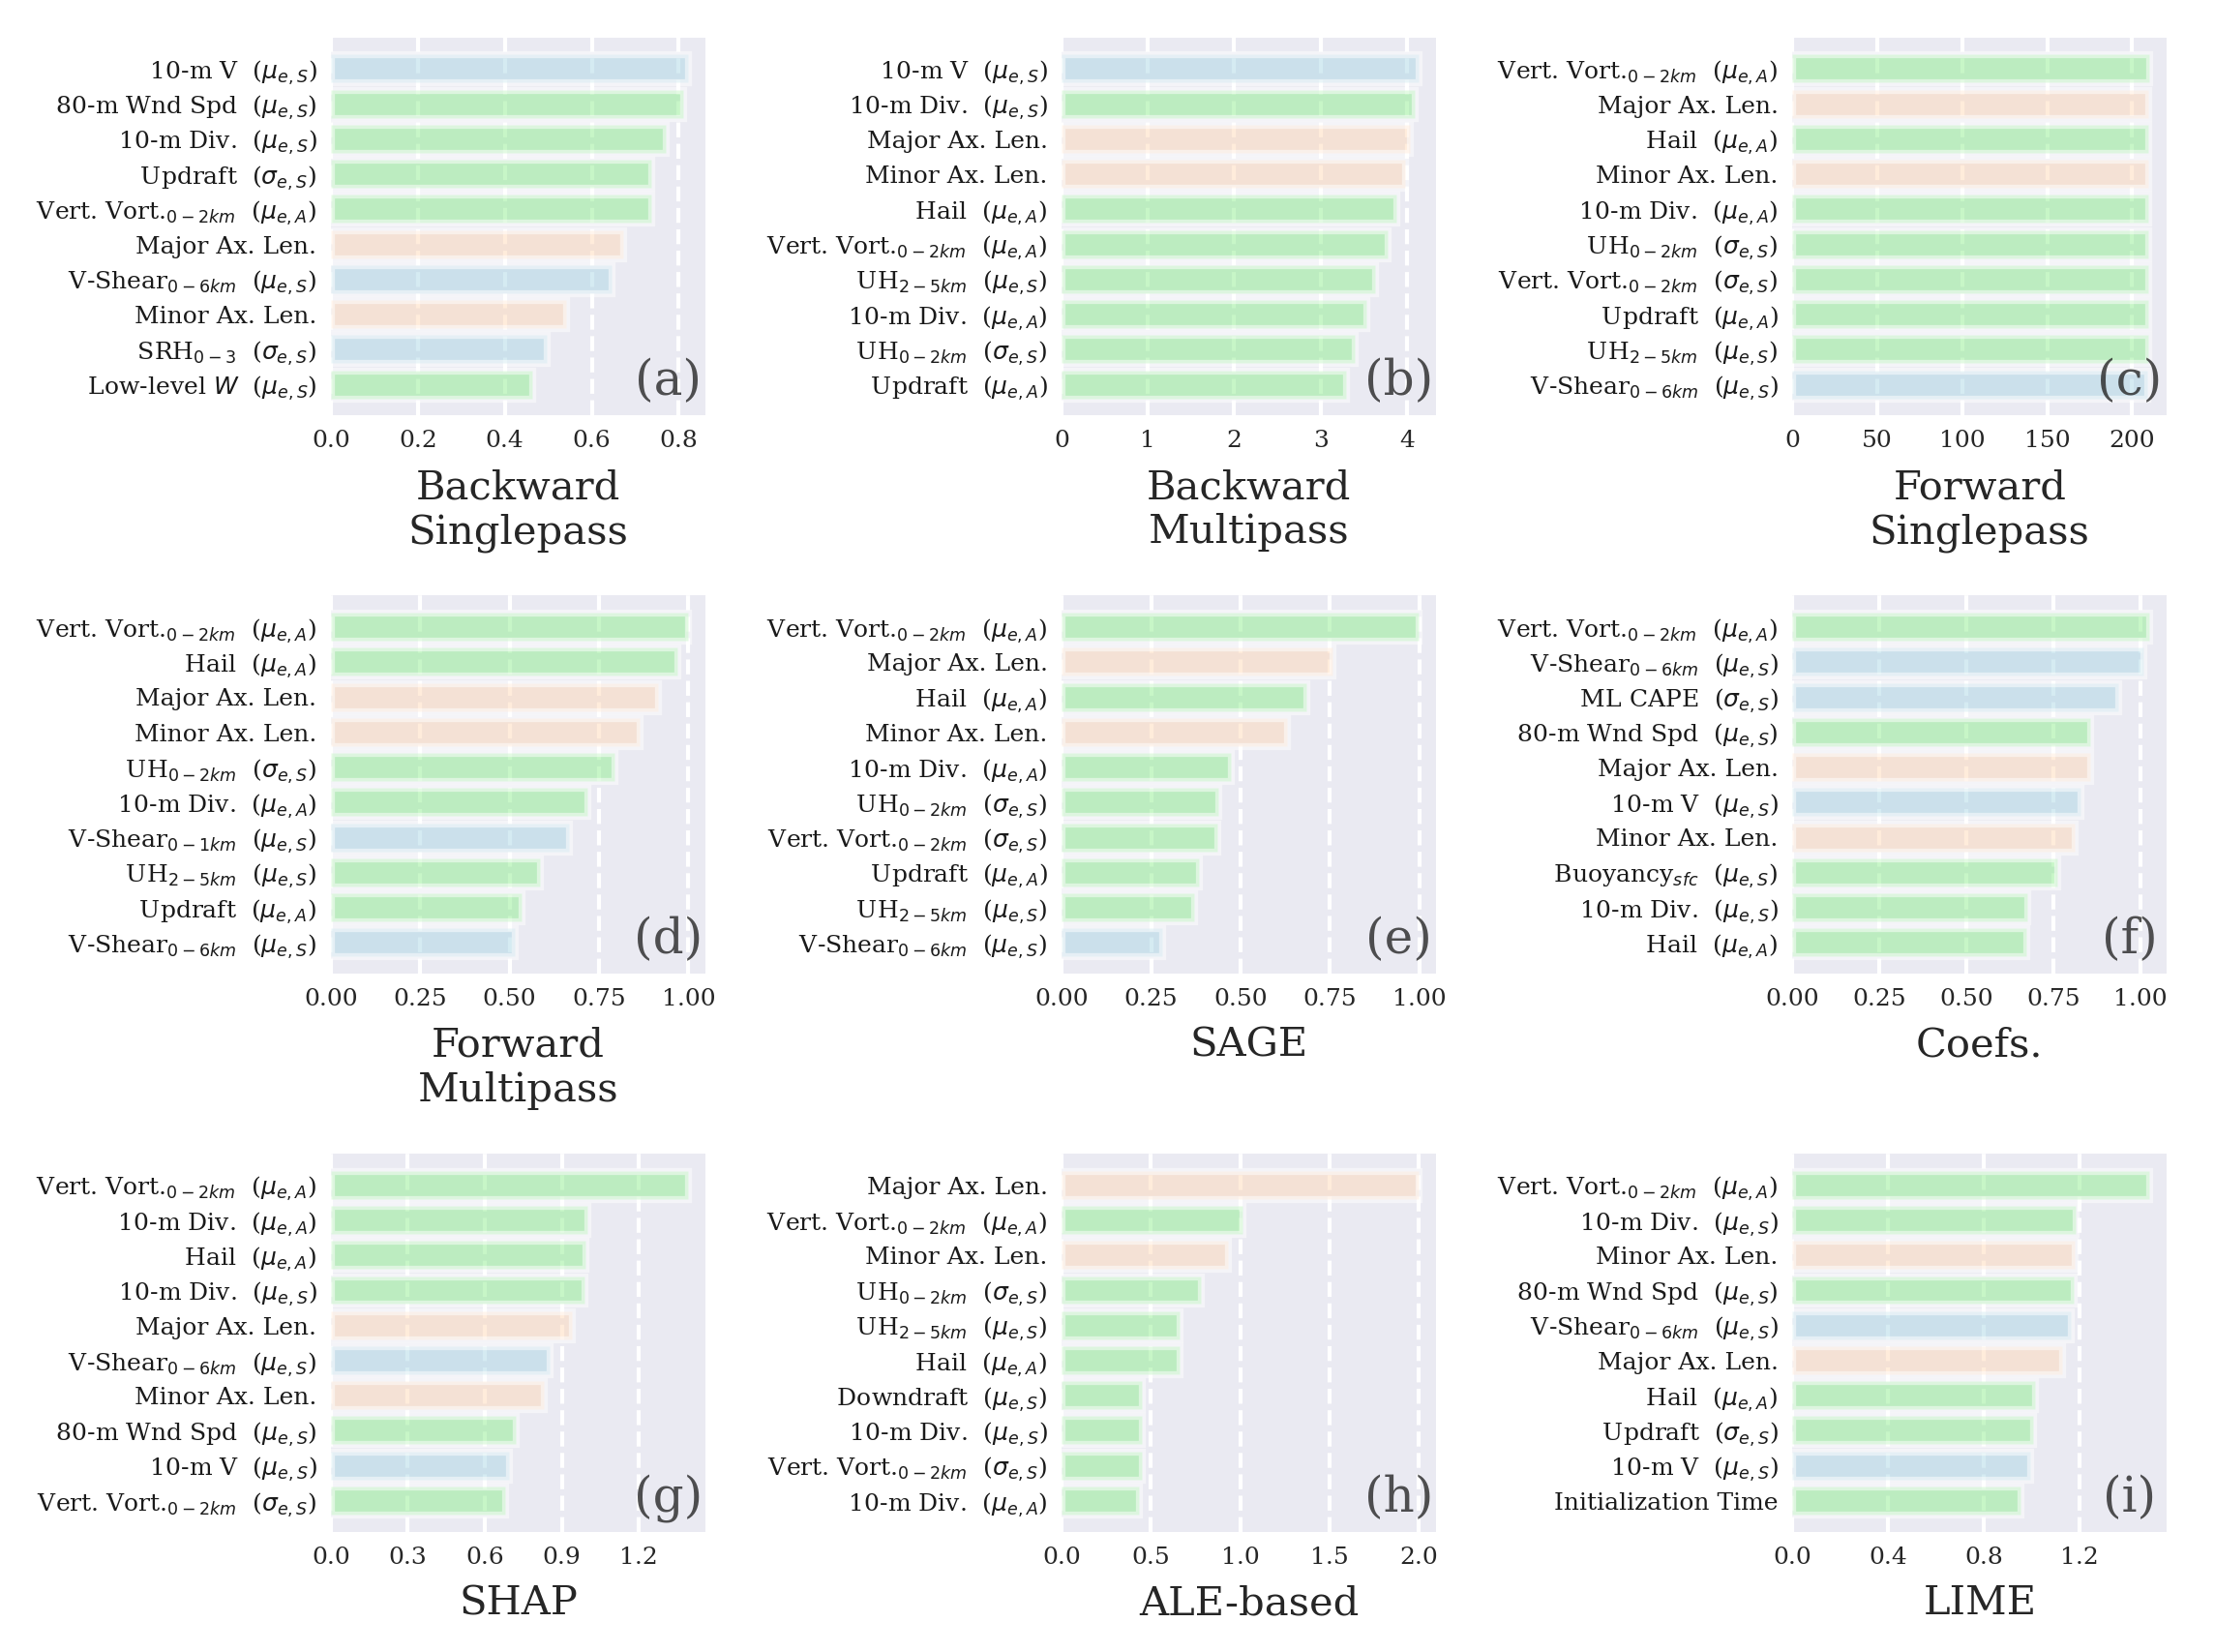

In [9]:
xlabels = ['Backward\nSinglepass', 'Backward\nMultipass', 'Forward\nSinglepass', 'Forward\nMultipass', 
           'SAGE', 'Coefs.', 'SHAP', 'ALE-based', 'LIME']

panels = [(m, n) for m, n in zip(methods, names)]
fig, axes = explainer.plot_importance(data=data, panels=panels, 
                                num_vars_to_plot=10, 
                                display_feature_names=display_feature_names,
                                feature_colors=feature_colors,
                                plot_correlated_features=False, 
                                n_columns=3,
                                xlabels=xlabels,
                                figsize=(8, 6), 
                                base_font_size= 12,
                                wspace=1.0, 
                                alphabet_fontsize=12, 
                                rho_threshold=0.6,
                                plot_reference_score=False,
                                plot_error=False, 
                               )
for ax in axes.flat:
    ax.xaxis.grid(ls='dashed')